Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# O conjunto de dados para incorporação de palavras com pré-treinamento
:label:`sec_word2vec_data`

Nesta seção, apresentaremos como pré-processar um conjunto de dados com amostragem negativa :numref:`sec_approx_train` e carregar em minibatches para treinamento word2vec. O conjunto de dados que usamos é [Penn Tree Bank (PTB)](https://catalog.ldc.upenn.edu/LDC99T42), que é um corpus pequeno, mas comumente usado. Ele pega amostras de artigos do Wall Street Journal e inclui conjuntos de treinamento, conjuntos de validação e conjuntos de teste.

Primeiro, importe os pacotes e módulos necessários para o experimento.


In [1]:
import math
import os
import random
import torch
from d2l import torch as d2l

## Leitura e pré-processamento do conjunto de dados

Este conjunto de dados já foi pré-processado. Cada linha do conjunto de dados atua como uma frase. Todas as palavras em uma frase são separadas por espaços. Na tarefa de incorporação de palavras, cada palavra é um token.


In [2]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    data_dir = d2l.download_extract('ptb')
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

Em seguida, construímos um vocabulário com palavras que aparecem no máximo 10 vezes mapeadas em um "&lt;unk&gt;" símbolo. Observe que os dados PTB pré-processados também contêm "&lt;unk&gt;" tokens apresentando palavras raras.


In [3]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

## Subamostragem

Em dados de texto, geralmente há algumas palavras que aparecem em altas frequências, como "the", "a" e "in" em inglês. De modo geral, em uma janela de contexto, é melhor treinar o modelo de incorporação de palavras quando uma palavra (como "chip") e uma palavra de frequência mais baixa (como "microprocessador") aparecem ao mesmo tempo, em vez de quando um palavra aparece com uma palavra de frequência mais alta (como "o"). Portanto, ao treinar o modelo de incorporação de palavras, podemos realizar subamostragem nas palavras :cite:`Mikolov.Sutskever.Chen.ea.2013`. Especificamente, cada palavra indexada $w_i$ no conjunto de dados desaparecerá com uma certa probabilidade. A probabilidade de abandono é dada como:

$$ P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),$$

Aqui, $f(w_i)$ é a proporção das instâncias da palavra $w_i$ para o número total de palavras no conjunto de dados, e a constante $t$ é um hiperparâmetro (definido como $10^{-4}$ neste experimentar). Como podemos ver, só é possível eliminar a palavra $w_i$ na subamostragem quando $f(w_i) > t$. Quanto mais alta a frequência da palavra, maior sua probabilidade de abandono.


In [4]:
#@save
def subsampling(sentences, vocab):
    # Map low frequency words into <unk>
    sentences = [[vocab.idx_to_token[vocab[tk]] for tk in line]
                 for line in sentences]
    # Count the frequency for each word
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    # Return True if to keep this token during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    # Now do the subsampling
    return [[tk for tk in line if keep(tk)] for line in sentences]

subsampled = subsampling(sentences, vocab)

Compare os comprimentos da sequência antes e depois da amostragem, podemos ver que a subamostragem reduziu significativamente o comprimento da sequência.


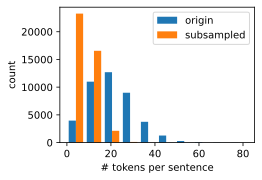

In [5]:
d2l.set_figsize()
d2l.plt.hist([[len(line) for line in sentences],
              [len(line) for line in subsampled]])
d2l.plt.xlabel('# tokens per sentence')
d2l.plt.ylabel('count')
d2l.plt.legend(['origin', 'subsampled']);

Para tokens individuais, a taxa de amostragem da palavra de alta frequência "the" é menor que 1/20.


In [6]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([line.count(token) for line in sentences])}, '
            f'after={sum([line.count(token) for line in subsampled])}')

compare_counts('the')

'# of "the": before=50770, after=2105'

Mas a palavra de baixa frequência "juntar" é completamente preservada.


In [7]:
compare_counts('join')

'# of "join": before=45, after=45'

Por último, mapeamos cada token em um índice para construir o corpus.


In [8]:
corpus = [vocab[line] for line in subsampled]
corpus[0:3]

[[0, 0], [392, 32, 2115, 5, 274, 406], [5277, 3054, 1580, 95]]

## Carregando o conjunto de dados

Em seguida, lemos o corpus com índices de token em lotes de dados para treinamento.

### Extração de palavras-alvo centrais e palavras de contexto

Usamos palavras com uma distância da palavra alvo central não excedendo o tamanho da janela de contexto como as palavras de contexto da palavra alvo central fornecida. A função de definição a seguir extrai todas as palavras-alvo centrais e suas palavras de contexto. Ele mostra de maneira uniforme e aleatória um inteiro para ser usado como o tamanho da janela de contexto entre o inteiro 1 e o `max_window_size` (janela de contexto máxima).


In [9]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # Each sentence needs at least 2 words to form a "central target word
        # - context word" pair
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the central target word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

A seguir, criamos um conjunto de dados artificial contendo duas sentenças de 7 e 3 palavras, respectivamente. Suponha que a janela de contexto máxima seja 2 e imprima todas as palavras-alvo centrais e suas palavras de contexto.


In [10]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2, 3]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [2, 4]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [3, 4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [8]


Definimos o tamanho máximo da janela de contexto como 5. O seguinte extrai todas as palavras-alvo centrais e suas palavras de contexto no conjunto de dados.


In [11]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {len(all_centers)}'

'# center-context pairs: 352636'

### Amostragem Negativa

Usamos amostragem negativa para treinamento aproximado. Para um par de palavras centrais e de contexto, amostramos aleatoriamente $K$ palavras de ruído ($K = 5$ no experimento). De acordo com a sugestão do artigo Word2vec, a probabilidade de amostragem de palavras de ruído $P(w)$ é a razão entre a frequência de palavras de $w$ e a frequência total de palavras elevada à potência de 0,75 :cite:`Mikolov.Sutskever. Chen.ea.2013`.

Primeiro definimos uma classe para desenhar um candidato de acordo com os pesos amostrais. Ele armazena em cache um banco de números aleatórios de tamanho 10.000 em vez de chamar `random.choices` todas as vezes.


In [12]:
#@save
class RandomGenerator:
    """Draw a random int in [0, n] according to n sampling weights."""
    def __init__(self, sampling_weights):
        self.population = list(range(len(sampling_weights)))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i-1]

generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[1, 0, 1, 2, 2, 0, 2, 2, 2, 2]

In [13]:
#@save
def get_negatives(all_contexts, corpus, K):
    counter = d2l.count_corpus(corpus)
    sampling_weights = [counter[i]**0.75 for i in range(len(counter))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, corpus, 5)

### Lendo em lotes

Extraímos todas as palavras-alvo centrais `all_centers`, e as palavras de contexto `all_contexts` e palavras de ruído `all_negatives` de cada palavra-alvo central do conjunto de dados. Vamos lê-los em minibatches aleatórios.

Em um minibatch de dados, o exemplo $i^\mathrm{th}$ inclui uma palavra central e suas correspondentes $n_i$ palavras de contexto e $m_i$ palavras de ruído. Visto que o tamanho da janela de contexto de cada exemplo pode ser diferente, a soma das palavras de contexto e palavras de ruído, $n_i+m_i$, será diferente. Ao construir um minibatch, concatenamos as palavras de contexto e as palavras de ruído de cada exemplo e adicionamos 0s para preenchimento até que o comprimento das concatenações sejam iguais, ou seja, o comprimento de todas as concatenações é $\max_i n_i+m_i$ (`max_len`). Para evitar o efeito do preenchimento no cálculo da função de perda, construímos a variável de máscara `masks`, cada elemento correspondendo a um elemento na concatenação de palavras de contexto e ruído,`contexts_negatives`. Quando um elemento na variável `contexts_negatives` é um preenchimento, o elemento na variável de máscara `masks` na mesma posição será 0. Caso contrário, ele assume o valor 1. Para distinguir entre exemplos positivos e negativos, nós também precisa distinguir as palavras de contexto das palavras de ruído na variável `contexts_negatives`. Com base na construção da variável de máscara, só precisamos criar uma variável de rótulo `labels` com a mesma forma da variável `contexts_negatives` e definir os elementos correspondentes às palavras de contexto (exemplos positivos) para 1, e o resto para 0 .

A seguir, implementaremos a função de leitura de minibatch `batchify`. Sua entrada de minibatch, `data`, é uma lista cujo comprimento é o tamanho do lote, cada elemento contendo palavras-alvo centrais `center`, palavras de contexto `context` e palavras de ruído `negative`. Os dados de minibatch retornados por esta função estão de acordo com o formato de que precisamos, por exemplo, inclui a variável de máscara.


In [14]:
#@save
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(contexts_negatives),
            torch.tensor(masks), torch.tensor(labels))

Construa dois exemplos simples:


In [15]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


Usamos a função `batchify` definida apenas para especificar o método de leitura de minibatch na instância `DataLoader`.

## Juntando todas as coisas

Por último, definimos a função `load_data_ptb` que lê o conjunto de dados PTB e retorna o iterador de dados.


In [16]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled = subsampling(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, corpus, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index], self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(
        all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify,
                                      num_workers=num_workers)
    return data_iter, vocab

Vamos imprimir o primeiro minibatch do iterador de dados.


In [17]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


## Sumário

* A subamostragem tenta minimizar o impacto de palavras de alta frequência no treinamento de um modelo de incorporação de palavras.
* Podemos preencher exemplos de comprimentos diferentes para criar minibatches com exemplos de todos os mesmos comprimentos e usar variáveis de máscara para distinguir entre elementos de preenchimento e não preenchimento, de modo que apenas elementos não preenchidos participem do cálculo da função de perda.

## Exercícios

1. Usamos a função `batchify` para especificar o método de leitura do minibatch na instância do `DataLoader` e imprimir a forma de cada variável na primeira leitura do lote. Como essas formas devem ser calculadas?


[Discussão](https://discuss.d2l.ai/t/1330)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMjk1NzExMjk1LDEwMTAyMzM0MCwtNDQzNT
M4NTUwLDE4MzM0NDcwNDZdfQ==
-->
